# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

### Pressure Swing Distillation

Separation of the Methanol and Acetone minimum temperature azeotrope by using the pressure sensitivity of the azeotropic composition of this mixture by operating two columns at different pressures, adapted from [Luyben et al. Ind.Eng.Chem.Res. (2008) 47 pp. 2696-2707.](http://pubs.acs.org/doi/pdf/10.1021/ie701695u).

The number of stages in this flowsheet differs from the specifications used in the ChemSep example.

[Link to the flowsheet drawing](http://www.chemsep.org/downloads/data/Pressure_Swing_MA_iecr47p2696.png)

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

# Set up Thermodynamics

In [5]:
sys= ThermodynamicSystem("Test2","NRTL", "default")

sys.AddComponent(Database.FindComponent("Acetone"))
sys.AddComponent(Database.FindComponent("Methanol"))
Database.FillBIPs(sys)

kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.MW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)

# Analysis of the Thermo System

In [6]:
def thermoAnalysis(psys):
    numComps=len(sys.Components)
    names=sys.GetComponentIds()

    numSteps=20    
    mixture= MaterialStream("Mix", sys)
    mixture.Specify("VF",0.0)
    mixture.Specify("P",psys, METRIC.mbar)
    for c in names:
        mixture.Specify("n["+c+"]",1.0)
    mixture.InitializeFromMolarFlows()
    mixture.FlashPZ()

    test= Flowsheet("test")
    test.AddMaterialStream(mixture)

    solver= num.DecompositionSolver(logger)
    result=solver.Solve(test)

    fig,axs=plt.subplots(numComps,numComps,figsize=(8,8))
    for i in range(numComps):
        for j in range(numComps):       
            if j!=i:
                xvec=[]
                yvec=[]
                for c in range(numSteps):
                    for k in range(numComps):                    
                        mixture.Specify("n["+names[k]+"]",0.0)
                    mixture.Specify("n["+names[i]+"]",c/(numSteps-1))
                    mixture.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
                    mixture.InitializeFromMolarFlows()
                    mixture.FlashPZ()
                    solver.Solve(test)                               
                    xvec.append(mixture.GetVariable('xL['+names[j]+']').Val())               
                    yvec.append(mixture.GetVariable('xV['+names[j]+']').Val())               
                axs[i,j].plot(xvec, yvec)
                axs[i,j].plot(xvec, xvec)              
                axs[i,j].set_title(names[j] +' in '+names[i])
                axs[i,j].set_xlabel('$x_{'+names[j]+'}$')       
                axs[i,j].set_ylabel('$y_{'+names[j]+'}$')
                axs[i, j].set_aspect('equal', 'box')
            else:
                axs[i, j].axis('off')        

    plt.tight_layout()
    logger.Flush()
    plt.suptitle('(x,y)-Diagram at '+str(round(psys,2))+' mbar', y=1.05);

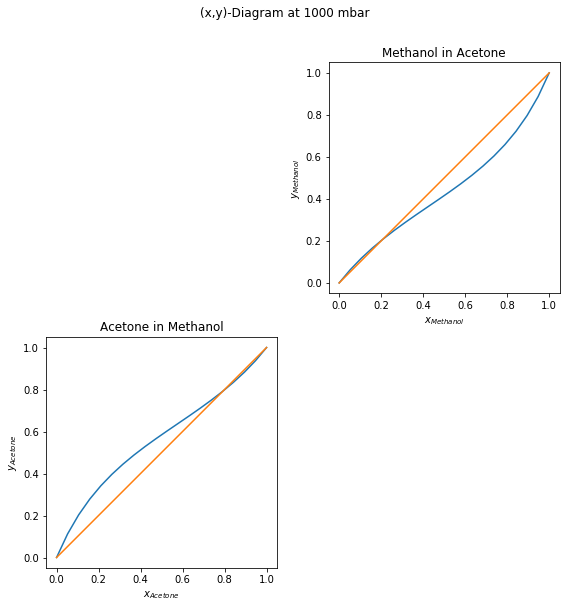

In [7]:
thermoAnalysis(1000)

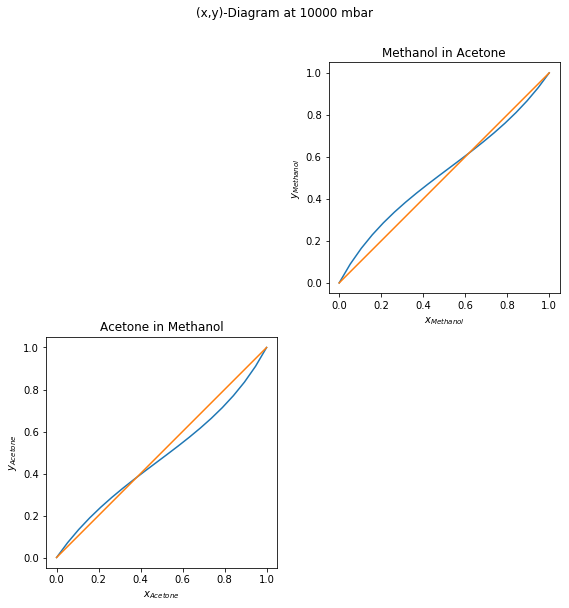

In [8]:
thermoAnalysis(10000)

# Low pressure column

In [9]:
Feed = (MaterialStream("Feed", sys)
    .Specify("T",43, METRIC.C)
    .Specify("P",1, METRIC.bar)
    .Specify("n[Acetone]", 270, kmolh)
    .Specify("n[Methanol]", 270, kmolh)
    .InitializeFromMolarFlows()
    .FlashPT())

Recycle = (MaterialStream("Recycle", sys)
    .Specify("T",54, METRIC.C)
    .Specify("P",10, METRIC.bar)
    .Specify("n[Acetone]",10, kmolh)
    .Specify("n[Methanol]", 170, kmolh)
    .InitializeFromMolarFlows()
    .FlashPZ())

S01 = MaterialStream("S01", sys)
S02 = MaterialStream("S02", sys)
S03 =(MaterialStream("S03", sys)
    .Init("T", 51, METRIC.C)
    .Init("P", 1, METRIC.bar)
    .Init("n[Acetone]",50, kmolh)
    .Init("n[Methanol]", 50, kmolh))

S04 = MaterialStream("S04", sys)
S05 = (MaterialStream("S05", sys)
    .Init("T", 61, METRIC.C)
    .Init("P", 1, METRIC.bar)
    .Init("n[Acetone]",2, kmolh)
    .Init("n[Methanol]", 100, kmolh))

Methanol = MaterialStream("Methanol", sys)
D1 = MaterialStream("D1", sys)

In [10]:
C1 = (EquilibriumStageSection("C1",sys,52)
        .Connect("VIn", S05)
        .Connect("LIn", S03)
        .Connect("VOut", S01)
        .Connect("LOut", S04)
        .ConnectFeed(Feed,37)
        .ConnectFeed(Recycle,41)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(2.3,0.25,logger))

REB1 =(Flash("REB1",sys)
        .Connect("In", S04)
        .Connect("Vap", S05)
        .Connect("Liq", Methanol)
        .Specify("P", 1, METRIC.bar)
        .Specify("VF",0.7)
        .Initialize())

COND1 = (Heater("COND1",sys)
        .Connect("In", S01)
        .Connect("Out", S02)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0)
        .Initialize())

RefluxRatio1=2.36
REFSPL1 = (Splitter("REFSPL1",sys)
        .Connect("In", S02)
        .Connect("Out1", S03)
        .Connect("Out2", D1)
        .Specify("DP",0, METRIC.bar)
        .Specify("K",RefluxRatio1/(1.0+RefluxRatio1))
        .Initialize())

C1.Initialize(1.0,0.25,logger)
logger.Flush();

In [11]:
flowsheet= (Flowsheet("Flow")
            .AddMaterialStreams(Feed, Recycle, S01,S02,S03,D1,S04,S05, Methanol)
            .AddUnits(C1, REB1, COND1, REFSPL1))

In [12]:
solver= num.DecompositionSolver(logger)

solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=768, E=768, Blocks=168, Singletons=160
Block Statistics:
   # Var # Blocks % Blocks
       1      160  95,24 %
       5        4   2,38 %
       6        3   1,79 %
     570        1   0,60 %
Problem NLAES was successfully solved (0,37 seconds)



In [13]:
reporter.Report(flowsheet, 5, False)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              43.0000     136.0140      55.0442      55.0345      55.0345
Pressure                  bar              1.0000      10.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -23755.2480    2085.9629  -29148.4951  -29148.4951
Phase                                      Liquid  LiquidVapor  LiquidVapor  BubblePoint  LiquidVapor

Total Molar Flow          kmol/h         540.0000     180.0000    1067.7376    1067.7376     749.9585
                  Acetone kmol/h         270.0000      10.0000     809.6313     809.6313     568.6696
                 Methanol kmol/h         270.0000     170.0000     258.1063     258.1063     181.

# Add High pressure column

In [14]:
S06 = MaterialStream("S06", sys)
S07 = MaterialStream("S07", sys)
S08 = (MaterialStream("S08", sys)
        .Init("T", 54, METRIC.C)
        .Init("P", 10, METRIC.bar)
        .Init("n[Acetone]",50, kmolh)
        .Init("n[Methanol]", 50, kmolh))

S09 = MaterialStream("S09", sys)

S10 = (MaterialStream("S10", sys)
        .Init("T", 140, METRIC.C)
        .Init("P", 10, METRIC.bar)
        .Init("n[Acetone]",100, kmolh)
        .Init("n[Methanol]", 2, kmolh))

Acetone = MaterialStream("Acetone", sys)
D2 = MaterialStream("D2", sys)

C2 = (EquilibriumStageSection("C2",sys,61)
        .Connect("VIn", S10)
        .Connect("LIn", S08)
        .Connect("VOut", S06)
        .Connect("LOut", S09)
        .ConnectFeed(D1,41)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(3.11,0.1,logger))

REB2 = (Flash("REB2",sys)
        .Connect("In", S09)
        .Connect("Vap", S10)
        .Connect("Liq", Acetone)
        .Specify("P",10, METRIC.bar)
        .Specify("VF",0.7)
        .Initialize())

COND2 = (Heater("COND2",sys)
        .Connect("In", S06)
        .Connect("Out", S07)
        .Specify("P",10, METRIC.bar)
        .Specify("VF",0)
        .Initialize())

RefluxRatio2=3.11
REFSPL2 = (Splitter("REFSPL2",sys)
        .Connect("In", S07)
        .Connect("Out1", D2)
        .Connect("Out2", S08)
        .Specify("DP",0, METRIC.bar)
        .Specify("K",1-RefluxRatio2/(1.0+RefluxRatio2))
        .Initialize())

C2.Solve()
REB2.Solve()
COND2.Solve()
REFSPL2.Solve()
C2.Initialize(3.11,0.1,logger)
logger.Flush();

In [15]:
flowsheet.AddMaterialStreams(S06,S07,S08,D2,S09,S10,Acetone)
flowsheet.AddUnits(C2, REB2, COND2, REFSPL2);

In [16]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1601, E=1601, Blocks=319, Singletons=305
Block Statistics:
   # Var # Blocks % Blocks
       1      305  95,61 %
       5        6   1,88 %
       6        6   1,88 %
     570        1   0,31 %
     660        1   0,31 %
Problem NLAES was successfully solved (0,30 seconds)



# Close Recycle

The stream recycle was fixed while we performed the startup calculations. Now we connect the recycle stream with the distillate stream of C2 to close the loop. We use a simple adiabatic heater to close the mass and energy balance.

In [17]:
Recycle.Unfix()

RECY01 = (Heater("RECY01",sys)
    .Connect("In", D2)
    .Connect("Out", Recycle)
    .Specify("DP",9, METRIC.bar)
    .Specify("Q",0, SI.kW)
    .Initialize()
    .Solve())

flowsheet.AddUnit(RECY01);

In [18]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1608, E=1608, Blocks=300, Singletons=287
Block Statistics:
   # Var # Blocks % Blocks
       1      287  95,67 %
       5        5   1,67 %
       6        7   2,33 %
    1254        1   0,33 %
Problem NLAES was successfully solved (0,46 seconds)



# Reach Specifications

In [19]:
REB1.Unspecify("VF")
REB2.Unspecify("VF")
Methanol.GetVariable("x[Methanol]").Fix(0.995)
Acetone.GetVariable("x[Acetone]").Fix(0.995)

In [20]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1608, E=1608, Blocks=296, Singletons=283
Block Statistics:
   # Var # Blocks % Blocks
       1      283  95,61 %
       5        5   1,69 %
       6        7   2,36 %
    1258        1   0,34 %
Problem NLAES was successfully solved (0,69 seconds)



In [21]:
reporter.Report(flowsheet, 6, False)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03           D1

Temperature               °C              43.0000      57.0129      55.0434      55.0341      55.0341      55.0340
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.3319       1.0000       0.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -20552.0239    2086.4014  -29144.8041  -29144.8041  -29144.8041
Phase                                      Liquid  LiquidVapor  LiquidVapor  BubblePoint  LiquidVapor       Liquid

Total Molar Flow          kmol/h         540.0000     183.4890    1523.7231    1523.7231    1070.2341     453.4890
                  Acetone kmol/h         270.0000      75.4489    1156.1723    1156.1723     812.0734     34

# Overall Mass Balance

For reporting purposes, we create a temporary flowsheet that collects the main process streams. This flowsheet will not be solved, but is used by the reporter object.

In [22]:
summary= Flowsheet("Summary").AddMaterialStreams(Feed, Recycle, Acetone, Methanol)

reporter.Report(summary, 4, False)
print (logger.Flush())            


Report for flowsheet Summary

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle      Acetone     Methanol

Temperature               °C              43.0000      57.0129     142.7177      64.0940
Pressure                  bar              1.0000       1.0000      10.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.3319       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -20552.0239  -13217.1897  -33642.1155
Phase                                      Liquid  LiquidVapor  LiquidVapor  LiquidVapor

Total Molar Flow          kmol/h         540.0000     183.4890     270.0000     270.0000
                  Acetone kmol/h         270.0000      75.4489     268.6500       1.3500
                 Methanol kmol/h         270.0000     108.0401       1.3500     268.6500
Molar Composition                    
                  Acetone mol/mol          0.5000       0.4112       0.

# Temperature Profiles

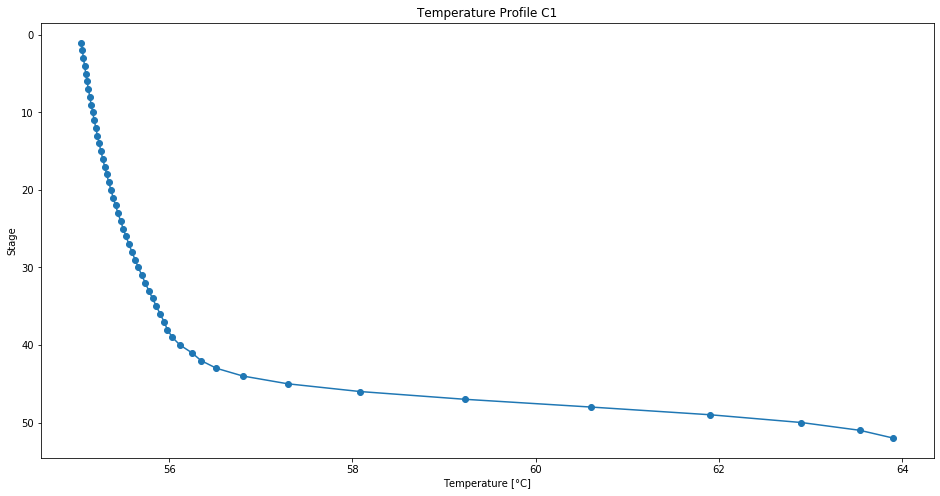

In [23]:
tprof=C1.GetProfile("T")
stages= range(1, C1.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile C1");


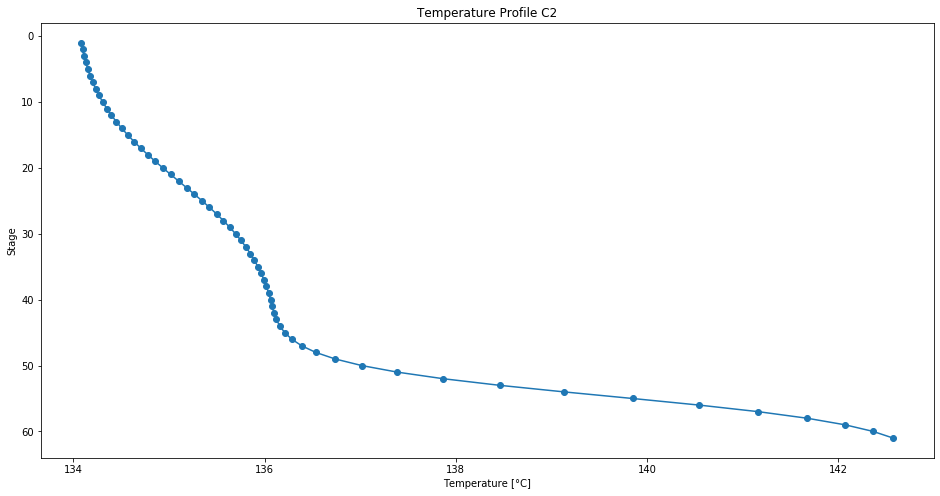

In [24]:
tprof=C2.GetProfile("T")
stages= range(1, C2.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile C2");